![](../../img/chinahadoop.png)

# LightGBM用法速查表


详细的细节内容可以参考[LightGBM中文文档](https://lightgbm.apachecn.org/#/)

## 内置方式建模
- 要把数据读取成Dataset格式
- lgb.train去训练

In [1]:
# coding: utf-8
import json
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error


# 加载数据集合
print('加载数据...')
df_train = pd.read_csv('./data/regression.train.txt', header=None, sep='\t')
df_test = pd.read_csv('./data/regression.test.txt', header=None, sep='\t')

# 设定训练集和测试集
y_train = df_train[0].values
y_test = df_test[0].values
X_train = df_train.drop(0, axis=1).values
X_test = df_test.drop(0, axis=1).values

# 构建lgb中的Dataset格式
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 敲定好一组参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('开始训练...')
# 训练
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

# 保存模型
print('保存模型...')
# 保存模型到文件中
gbm.save_model('model.txt')

print('开始预测...')
# 预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# 评估
print('预估结果的rmse为:')
print(mean_squared_error(y_test, y_pred) ** 0.5)

加载数据...
开始训练...
[1]	valid_0's l2: 0.24288	valid_0's auc: 0.764496
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.239307	valid_0's auc: 0.766173
[3]	valid_0's l2: 0.235559	valid_0's auc: 0.785547
[4]	valid_0's l2: 0.230771	valid_0's auc: 0.797786
[5]	valid_0's l2: 0.226297	valid_0's auc: 0.805155
[6]	valid_0's l2: 0.223692	valid_0's auc: 0.800979
[7]	valid_0's l2: 0.220941	valid_0's auc: 0.806566
[8]	valid_0's l2: 0.217982	valid_0's auc: 0.808566
[9]	valid_0's l2: 0.215351	valid_0's auc: 0.809041
[10]	valid_0's l2: 0.213064	valid_0's auc: 0.805953
[11]	valid_0's l2: 0.211053	valid_0's auc: 0.804631
[12]	valid_0's l2: 0.209336	valid_0's auc: 0.802922
[13]	valid_0's l2: 0.207492	valid_0's auc: 0.802011
[14]	valid_0's l2: 0.206016	valid_0's auc: 0.80193
Early stopping, best iteration is:
[9]	valid_0's l2: 0.215351	valid_0's auc: 0.809041
保存模型...
开始预测...
预估结果的rmse为:
0.4640593794679212


## 添加样本权重训练

In [2]:
# coding: utf-8
import json
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 加载数据集
print('加载数据...')
df_train = pd.read_csv('./data/binary.train', header=None, sep='\t')
df_test = pd.read_csv('./data/binary.test', header=None, sep='\t')
W_train = pd.read_csv('./data/binary.train.weight', header=None)[0]
W_test = pd.read_csv('./data/binary.test.weight', header=None)[0]

y_train = df_train[0].values
y_test = df_test[0].values
X_train = df_train.drop(0, axis=1).values
X_test = df_test.drop(0, axis=1).values

num_train, num_feature = X_train.shape

# 加载数据的同时加载权重
lgb_train = lgb.Dataset(X_train, y_train,
                        weight=W_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,
                       weight=W_test, free_raw_data=False)

# 设定参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# 产出特征名称
feature_name = ['feature_' + str(col) for col in range(num_feature)]

print('开始训练...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_train,  # 评估训练集
                feature_name=feature_name,
                categorical_feature=[21])

加载数据...
开始训练...
[1]	training's binary_logloss: 0.68205
[2]	training's binary_logloss: 0.673618
[3]	training's binary_logloss: 0.665891
[4]	training's binary_logloss: 0.656874
[5]	training's binary_logloss: 0.648523
[6]	training's binary_logloss: 0.641874
[7]	training's binary_logloss: 0.636029
[8]	training's binary_logloss: 0.629427
[9]	training's binary_logloss: 0.623354
[10]	training's binary_logloss: 0.617593


## 模型的载入与预测

In [3]:
# 查看特征名称
print('完成10轮训练...')
print('第7个特征为:')
print(repr(lgb_train.feature_name[6]))

# 存储模型
gbm.save_model('./model/lgb_model.txt')

# 特征名称
print('特征名称:')
print(gbm.feature_name())

# 特征重要度
print('特征重要度:')
print(list(gbm.feature_importance()))

# 加载模型
print('加载模型用于预测')
bst = lgb.Booster(model_file='./model/lgb_model.txt')
# 预测
y_pred = bst.predict(X_test)
# 在测试集评估效果
print('在测试集上的rmse为:')
print(mean_squared_error(y_test, y_pred) ** 0.5)

完成10轮训练...
第7个特征为:
'feature_6'
特征名称:
['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27']
特征重要度:
[8, 5, 1, 19, 7, 33, 2, 0, 2, 10, 5, 2, 0, 9, 3, 3, 0, 2, 2, 5, 1, 0, 36, 3, 33, 45, 29, 35]
加载模型用于预测
在测试集上的rmse为:
0.4629245607636925


## 接着之前的模型继续训练

In [4]:
# 继续训练
# 从./model/model.txt中加载模型初始化
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model='./model/lgb_model.txt',
                valid_sets=lgb_eval)

print('以旧模型为初始化，完成第 10-20 轮训练...')

# 在训练的过程中调整超参数
# 比如这里调整的是学习率
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                valid_sets=lgb_eval)

print('逐步调整学习率完成第 20-30 轮训练...')

# 调整其他超参数
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                valid_sets=lgb_eval,
                callbacks=[lgb.reset_parameter(bagging_fraction=[0.7] * 5 + [0.6] * 5)])

print('逐步调整bagging比率完成第 30-40 轮训练...')

[11]	valid_0's binary_logloss: 0.616177
[12]	valid_0's binary_logloss: 0.611792
[13]	valid_0's binary_logloss: 0.607043
[14]	valid_0's binary_logloss: 0.602314
[15]	valid_0's binary_logloss: 0.598433
[16]	valid_0's binary_logloss: 0.595238
[17]	valid_0's binary_logloss: 0.592047
[18]	valid_0's binary_logloss: 0.588673
[19]	valid_0's binary_logloss: 0.586084
[20]	valid_0's binary_logloss: 0.584033
以旧模型为初始化，完成第 10-20 轮训练...
[21]	valid_0's binary_logloss: 0.616177
[22]	valid_0's binary_logloss: 0.611834
[23]	valid_0's binary_logloss: 0.607177
[24]	valid_0's binary_logloss: 0.602577
[25]	valid_0's binary_logloss: 0.59831
[26]	valid_0's binary_logloss: 0.595259
[27]	valid_0's binary_logloss: 0.592201
[28]	valid_0's binary_logloss: 0.589017
[29]	valid_0's binary_logloss: 0.586597
[30]	valid_0's binary_logloss: 0.584454
逐步调整学习率完成第 20-30 轮训练...
[31]	valid_0's binary_logloss: 0.616053
[32]	valid_0's binary_logloss: 0.612291
[33]	valid_0's binary_logloss: 0.60856
[34]	valid_0's binary_logloss: 0

## 自定义损失函数

In [5]:
# 类似在xgboost中的形式
# 自定义损失函数需要
def loglikelood(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1. - preds)
    return grad, hess


# 自定义评估函数
def binary_error(preds, train_data):
    labels = train_data.get_label()
    return 'error', np.mean(labels != (preds > 0.5)), False


gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                fobj=loglikelood,
                feval=binary_error,
                valid_sets=lgb_eval)

print('用自定义的损失函数与评估标准完成第40-50轮...')

[41]	valid_0's binary_logloss: 0.614429	valid_0's error: 0.268
[42]	valid_0's binary_logloss: 0.610689	valid_0's error: 0.26
[43]	valid_0's binary_logloss: 0.606267	valid_0's error: 0.264
[44]	valid_0's binary_logloss: 0.601949	valid_0's error: 0.258
[45]	valid_0's binary_logloss: 0.597271	valid_0's error: 0.266
[46]	valid_0's binary_logloss: 0.593971	valid_0's error: 0.276
[47]	valid_0's binary_logloss: 0.591427	valid_0's error: 0.278
[48]	valid_0's binary_logloss: 0.588301	valid_0's error: 0.284
[49]	valid_0's binary_logloss: 0.586562	valid_0's error: 0.288
[50]	valid_0's binary_logloss: 0.584056	valid_0's error: 0.288
用自定义的损失函数与评估标准完成第40-50轮...


## sklearn与LightGBM配合使用
### LightGBM建模，sklearn评估

In [6]:
# coding: utf-8
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 加载数据
print('加载数据...')
df_train = pd.read_csv('./data/regression.train.txt', header=None, sep='\t')
df_test = pd.read_csv('./data/regression.test.txt', header=None, sep='\t')

# 取出特征和标签
y_train = df_train[0].values
y_test = df_test[0].values
X_train = df_train.drop(0, axis=1).values
X_test = df_test.drop(0, axis=1).values

print('开始训练...')
# 直接初始化LGBMRegressor
# 这个LightGBM的Regressor和sklearn中其他Regressor基本是一致的
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

# 使用fit函数拟合
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

# 预测
print('开始预测...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# 评估预测结果
print('预测结果的rmse是:')
print(mean_squared_error(y_test, y_pred) ** 0.5)

加载数据...
开始训练...
[1]	valid_0's l1: 0.491735
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.486563
[3]	valid_0's l1: 0.481489
[4]	valid_0's l1: 0.476848
[5]	valid_0's l1: 0.47305
[6]	valid_0's l1: 0.469049
[7]	valid_0's l1: 0.465556
[8]	valid_0's l1: 0.462208
[9]	valid_0's l1: 0.458676
[10]	valid_0's l1: 0.454998
[11]	valid_0's l1: 0.452047
[12]	valid_0's l1: 0.449158
[13]	valid_0's l1: 0.44608
[14]	valid_0's l1: 0.443554
[15]	valid_0's l1: 0.440643
[16]	valid_0's l1: 0.437687
[17]	valid_0's l1: 0.435454
[18]	valid_0's l1: 0.433288
[19]	valid_0's l1: 0.431297
[20]	valid_0's l1: 0.428946
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 0.428946
开始预测...
预测结果的rmse是:
0.4441153344254208


### 网格搜索查找最优超参数

In [7]:
# 配合scikit-learn的网格搜索交叉验证选择最优超参数
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)

print('用网格搜索找到的最优超参数为:')
print(gbm.best_params_)

用网格搜索找到的最优超参数为:
{'learning_rate': 0.1, 'n_estimators': 40}


### 绘图解释

加载数据...
开始训练...
[10]	training's l2: 0.217995	training's l1: 0.457448	valid_1's l2: 0.21641	valid_1's l1: 0.456464
[20]	training's l2: 0.205099	training's l1: 0.436869	valid_1's l2: 0.201616	valid_1's l1: 0.434057
[30]	training's l2: 0.197421	training's l1: 0.421302	valid_1's l2: 0.192514	valid_1's l1: 0.417019
[40]	training's l2: 0.192856	training's l1: 0.411107	valid_1's l2: 0.187258	valid_1's l1: 0.406303
[50]	training's l2: 0.189593	training's l1: 0.403695	valid_1's l2: 0.183688	valid_1's l1: 0.398997
[60]	training's l2: 0.187043	training's l1: 0.398704	valid_1's l2: 0.181009	valid_1's l1: 0.393977
[70]	training's l2: 0.184982	training's l1: 0.394876	valid_1's l2: 0.178803	valid_1's l1: 0.389805
[80]	training's l2: 0.1828	training's l1: 0.391147	valid_1's l2: 0.176799	valid_1's l1: 0.386476
[90]	training's l2: 0.180817	training's l1: 0.388101	valid_1's l2: 0.175775	valid_1's l1: 0.384404
[100]	training's l2: 0.179171	training's l1: 0.385174	valid_1's l2: 0.175321	valid_1's l1: 0.382

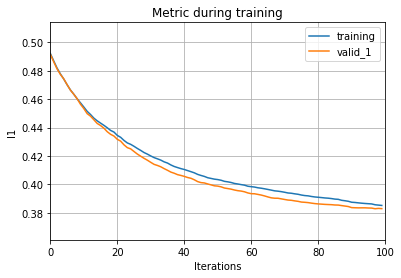

画出特征重要度...


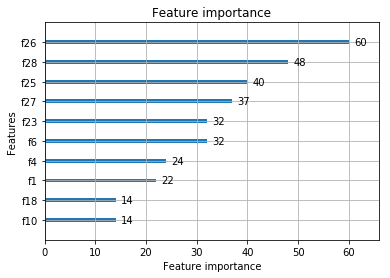

画出第84颗树...


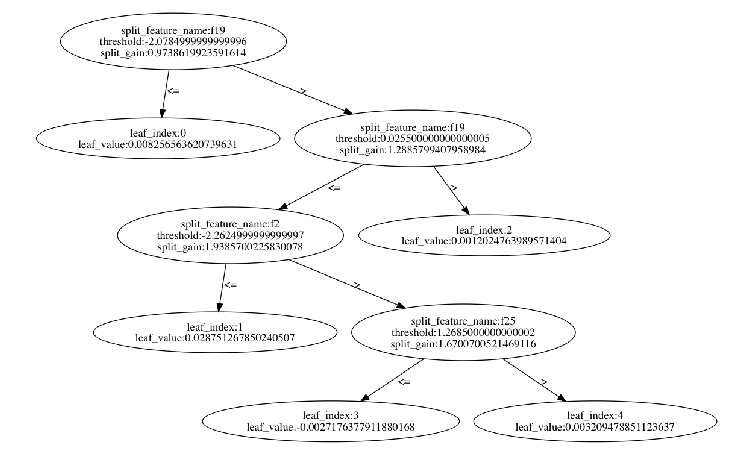

In [9]:
# coding: utf-8
import lightgbm as lgb
import pandas as pd

try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plotting.')

# 加载数据集
print('加载数据...')
df_train = pd.read_csv('./data/regression.train.txt', header=None, sep='\t')
df_test = pd.read_csv('./data/regression.test.txt', header=None, sep='\t')

# 取出特征和标签
y_train = df_train[0].values
y_test = df_test[0].values
X_train = df_train.drop(0, axis=1).values
X_test = df_test.drop(0, axis=1).values

# 构建lgb中的Dataset数据格式
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# 设定参数
params = {
    'num_leaves': 5,
    'metric': ('l1', 'l2'),
    'verbose': 0
}

evals_result = {}  # to record eval results for plotting

print('开始训练...')
# 训练
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=['f' + str(i + 1) for i in range(28)],
                categorical_feature=[21],
                evals_result=evals_result,
                verbose_eval=10)

print('在训练过程中绘图...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

print('画出特征重要度...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

print('画出第84颗树...')
ax = lgb.plot_tree(gbm, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
plt.show()

#print('用graphviz画出第84颗树...')
#graph = lgb.create_tree_digraph(gbm, tree_index=83, name='Tree84')
#graph.render(view=True)